# Movie Recommendation System

Gautam Naik (gautamnaik1994@gmail.com)  
Github Link: https://github.com/gautamnaik1994/MovieRecommendationMLCaseStudy


[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/gautamnaik1994/MovieRecommendationMLCaseStudy/blob/main/notebooks/CaseStudy.ipynb?flush_cache=true)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gautamnaik1994/MovieRecommendationMLCaseStudy/blob/main/notebooks/CaseStudy.ipynb)

**About Zee Entertainment**

Zee Entertainment Enterprises is an Indian media conglomerate, headquartered in Mumbai, India. It has interests in television, print, internet, film, and businesses related to mobile content, and operates 45 channels worldwide.

**Business Problem**  
Zee Entertainement want to enhance user experience on their OTT platform by recommending movies to users based on their past viewing history and preferences. They want to build a recommendation system that can predict the movies that a user is likely to watch based on their past viewing history and preferences.  
The insights gained from this system are expected to drive user engagement,
increase satisfaction, and foster a more intuitive user experience.

**Solution**

We will build a recommendation system that will predict the movies that a user is likely to watch based on their past viewing history and preferences. We will use the following approaches to build the recommendation system:

- Pearson Correlation 
- Cosine Similarity
- Matrix Factorization 

**Metrics used**

We will use RMSE and MAPE for evaluating the performance of the recommendation system.

**Dataset**  

1.Rating Data

Contains user ratings for movies on a 5-star scale.
Includes a timestamp representing when the rating was given.
Each user has rated at least 20 movies.

| Column    | Explanation                                                                 |
|-----------|-----------------------------------------------------------------------------|
| UserID    | Unique identifier for each user                                             |
| MovieID   | Unique identifier for each movie                                            |
| Rating    | User's rating for the movie on a 5-star scale                               |
| Timestamp | The time when the rating was given, represented as a Unix timestamp         |


2.User Data

Demographic data is voluntarily provided by users and varies in accuracy
and completeness.

| Column     | Explanation                                                                 |
|------------|-----------------------------------------------------------------------------|
| UserID     | Unique identifier for each user                                             |
| Gender     | Gender of the user (e.g., M for male, F for female)                         |
| Age        | Age group of the user                                                       |
| Occupation | Occupation of the user                                                      |
| Zip-code   | Zip code of the user's location                                             |

3.Movie Data


| Column    | Explanation                                                                 |
|-----------|-----------------------------------------------------------------------------|
| MovieID   | Unique identifier for each movie                                            |
| Title     | Title of the movie                                                          |
| Genres    | Genres of the movie, categorized into multiple types and pipe-separated     |


In [1]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
import duckdb as db
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.decomposition import TruncatedSVD

# Data Loading and Preprocessing

In [3]:
movies = pd.read_csv("../data/raw/zee-movies.dat", sep="::", encoding='ISO-8859-1', engine="python").to_parquet("../data/raw/movies.parquet")
ratings = pd.read_csv("../data/raw/zee-ratings.dat", sep="::", encoding='ISO-8859-1', engine="python").to_parquet("../data/raw/ratings.parquet")
users = pd.read_csv("../data/raw/zee-users.dat", sep="::", encoding='ISO-8859-1', engine="python").to_parquet("../data/raw/users.parquet")

In [2]:
movies = pl.read_parquet("../data/raw/movies.parquet")
ratings = pl.read_parquet("../data/raw/ratings.parquet")
users = pl.read_parquet("../data/raw/users.parquet")

**Movies**

In [3]:
movies.head()

Movie ID,Title,Genres
i64,str,str
1,"""Toy Story (1995)""","""Animation|Children's|Comedy"""
2,"""Jumanji (1995)""","""Adventure|Children's|Fantasy"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama"""
5,"""Father of the Bride Part II (1…","""Comedy"""


In [4]:
movies.shape

(3883, 3)

In [5]:
movies=movies.with_columns(
    pl.col("Title").str.extract(r"\((\d{4})\)", group_index=1).alias("ReleaseYear")
)
movies=movies.rename({"Movie ID":"MovieID"})
movies.head()

MovieID,Title,Genres,ReleaseYear
i64,str,str,str
1,"""Toy Story (1995)""","""Animation|Children's|Comedy""","""1995"""
2,"""Jumanji (1995)""","""Adventure|Children's|Fantasy""","""1995"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance""","""1995"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama""","""1995"""
5,"""Father of the Bride Part II (1…","""Comedy""","""1995"""


In [6]:
movies_expanded=movies.with_columns(
    pl.col("Genres").str.split("|").alias("Genres")
).explode("Genres").to_pandas()


movies_expanded = movies_expanded.pivot_table(index="MovieID", columns="Genres", aggfunc='size', fill_value=0)
movies_expanded

Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3949,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [7]:
movies_expanded.to_parquet("../data/processed/movies_expanded.parquet")

**Users**

In [8]:
users.head()

UserID,Gender,Age,Occupation,Zip-code
i64,str,i64,i64,str
1,"""F""",1,10,"""48067"""
2,"""M""",56,16,"""70072"""
3,"""M""",25,15,"""55117"""
4,"""M""",45,7,"""02460"""
5,"""M""",25,20,"""55455"""


In [9]:
users.shape

(6040, 5)

In [10]:
users=users.rename({"Zip-code":"ZipCode"})
occupations = pl.read_csv("../data/processed/occupations.csv")
ages = pl.read_csv("../data/processed/ages.csv")
users=users.join(occupations, on="Occupation", how="left").join(ages, on="Age", how="left").drop("Occupation")
users.head()

UserID,Gender,Age,ZipCode,OccupationName,AgeCategory
i64,str,i64,str,str,str
1,"""F""",1,"""48067""","""K-12 student""","""Under-18"""
2,"""M""",56,"""70072""","""self-employed""","""56+"""
3,"""M""",25,"""55117""","""scientist""","""25-34"""
4,"""M""",45,"""02460""","""executive/managerial""","""45-49"""
5,"""M""",25,"""55455""","""writer""","""25-34"""


In [11]:
users.describe()

statistic,UserID,Gender,Age,ZipCode,OccupationName,AgeCategory
str,f64,str,f64,str,str,str
"""count""",6040.0,"""6040""",6040.0,"""6040""","""6040""","""6040"""
"""null_count""",0.0,"""0""",0.0,"""0""","""0""","""0"""
"""mean""",3020.5,null,30.639238,null,null,null
"""std""",1743.742145,null,12.895962,null,null,null
"""min""",1.0,"""F""",1.0,"""00231""","""K-12 student""","""18-24"""
"""25%""",1511.0,null,25.0,null,null,null
"""50%""",3021.0,null,25.0,null,null,null
"""75%""",4530.0,null,35.0,null,null,null
"""max""",6040.0,"""M""",56.0,"""99945""","""writer""","""Under-18"""


**Ratings**

In [12]:
ratings.head()

UserID,MovieID,Rating,Timestamp
i64,i64,i64,i64
1,1193,5,978300760
1,661,3,978302109
1,914,3,978301968
1,3408,4,978300275
1,2355,5,978824291


In [13]:
ratings.shape, ratings["MovieID"].n_unique()

((1000209, 4), 3706)

In [14]:
ratings=ratings.join(movies, on="MovieID", how="left")
ratings=ratings.with_columns(
       pl.from_epoch("Timestamp", time_unit="s")
)
ratings = ratings.with_columns([
    pl.col("Timestamp").dt.year().alias("Year"),
    pl.col("Timestamp").dt.month().alias("Month"),
    pl.col("Timestamp").dt.day().alias("Day"),
    pl.col("Timestamp").dt.weekday().alias("Weekday"),
    pl.col("Timestamp").dt.hour().alias("Hour"),
    pl.col("Timestamp").dt.strftime('%A').alias("WeekdayName"),
    (pl.col("Timestamp").dt.weekday() >= 5).alias("IsWeekend"),
])

ratings=db.sql("""
    select *, 
        round(avg(Rating) over(partition by MovieID),3) AvgMovieRating,
        count(*) over(partition by MovieID) TotalMovieRatings,
        round(avg(Rating) over(partition by UserID),3) AvgUserRating,
        count(*) over(partition by UserID) TotalUserRatings
        from ratings
""").pl()


<Axes: >

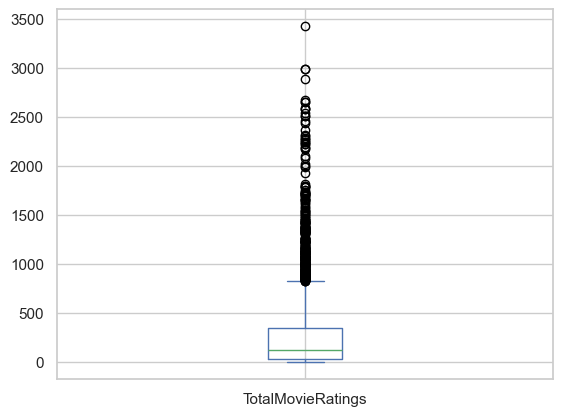

In [14]:
ratings.select("MovieID", "TotalMovieRatings").unique().to_pandas()["TotalMovieRatings"].plot(kind="box")

In [15]:
ratings.describe()

statistic,UserID,MovieID,Rating,Timestamp,Title,Genres,ReleaseYear,Year,Month,Day,Weekday,Hour,WeekdayName,IsWeekend,AvgMovieRating,TotalMovieRatings,AvgUserRating,TotalUserRatings
str,f64,f64,f64,str,str,str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""",1.000209e6,1.000209e6,1.000209e6,"""1000209""","""1000209""","""1000209""","""1000209""",1.000209e6,1.000209e6,1.000209e6,1.000209e6,1.000209e6,"""1000209""",1.000209e6,1.000209e6,1.000209e6,1.000209e6,1.000209e6
"""null_count""",0.0,0.0,0.0,"""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",3024.512348,1865.539898,3.581564,"""2000-10-22 19:41:35.404665""",null,null,null,2000.126168,8.710371,15.440691,3.800285,11.9162,null,0.383028,3.581561,816.23552,3.58156,389.908044
"""std""",1728.412695,1096.040689,1.117102,null,null,null,null,0.422392,2.71747,8.888445,2.04252,7.894465,null,null,0.545762,662.781251,0.436136,324.740247
"""min""",1.0,1.0,1.0,"""2000-04-25 23:05:32""","""$1,000,000 Duck (1971)""","""Action""","""1919""",2000.0,1.0,1.0,1.0,0.0,"""Friday""",0.0,1.0,1.0,1.015,20.0
"""25%""",1506.0,1030.0,3.0,"""2000-08-03 11:37:17""",null,null,null,2000.0,7.0,7.0,2.0,4.0,null,null,3.262,315.0,3.32,147.0
"""50%""",3070.0,1835.0,4.0,"""2000-10-31 18:46:46""",null,null,null,2000.0,9.0,17.0,4.0,14.0,null,null,3.68,645.0,3.615,302.0
"""75%""",4476.0,2770.0,4.0,"""2000-11-26 06:42:19""",null,null,null,2000.0,11.0,22.0,6.0,19.0,null,null,3.976,1124.0,3.883,544.0
"""max""",6040.0,3952.0,5.0,"""2003-02-28 17:49:50""","""eXistenZ (1999)""","""Western""","""2000""",2003.0,12.0,31.0,7.0,23.0,"""Wednesday""",1.0,5.0,3428.0,4.963,2314.0


In [16]:
weighted_ratings=ratings.select("MovieID", "TotalMovieRatings", "AvgMovieRating").unique().with_columns(
    WeightedAverageMovieRating=(((pl.col("TotalMovieRatings") * pl.col("AvgMovieRating")
                        ) + pl.lit(350))/(pl.lit(100)+pl.col("TotalMovieRatings")))
)
weighted_ratings

MovieID,TotalMovieRatings,AvgMovieRating,WeightedAverageMovieRating
i64,i64,f64,f64
3742,234,3.97,3.829281
245,11,3.0,3.45045
3077,88,4.227,3.840298
2368,58,1.69,2.83557
1306,136,3.603,3.559356
…,…,…,…
1009,291,3.186,3.266307
3068,379,3.865,3.7888
1224,426,4.286,4.13657


In [17]:
weighted_ratings.describe()

statistic,MovieID,TotalMovieRatings,AvgMovieRating,WeightedAverageMovieRating
str,f64,f64,f64,f64
"""count""",3706.0,3706.0,3706.0,3706.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",1995.573125,269.889099,3.23889,3.434259
"""std""",1151.148045,384.047838,0.672922,0.332625
"""min""",1.0,1.0,1.0,2.038376
"""25%""",989.0,33.0,2.822,3.263614
"""50%""",2034.0,124.0,3.332,3.466667
"""75%""",2991.0,350.0,3.741,3.595861
"""max""",3952.0,3428.0,5.0,4.509663


In [18]:
ratings=ratings.join(weighted_ratings.select("MovieID", "WeightedAverageMovieRating"), on="MovieID", how="left")
ratings.head()

UserID,MovieID,Rating,Timestamp,Title,Genres,ReleaseYear,Year,Month,Day,Weekday,Hour,WeekdayName,IsWeekend,AvgMovieRating,TotalMovieRatings,AvgUserRating,TotalUserRatings,WeightedAverageMovieRating
i64,i64,i64,datetime[μs],str,str,str,i32,i8,i8,i8,i8,str,bool,f64,i64,f64,i64,f64
4,1097,4,2000-12-31 20:19:24,"""E.T. the Extra-Terrestrial (19…","""Children's|Drama|Fantasy|Sci-F…","""1982""",2000,12,31,7,20,"""Sunday""",true,3.965,2269,4.19,21,3.945371
4,2951,4,2000-12-31 20:24:42,"""Fistful of Dollars, A (1964)""","""Action|Western""","""1964""",2000,12,31,7,20,"""Sunday""",true,3.994,522,4.19,21,3.914579
4,3418,4,2000-12-31 20:24:20,"""Thelma & Louise (1991)""","""Action|Drama""","""1991""",2000,12,31,7,20,"""Sunday""",true,3.68,1417,4.19,21,3.668134
4,2366,4,2000-12-31 20:23:50,"""King Kong (1933)""","""Action|Adventure|Horror""","""1933""",2000,12,31,7,20,"""Sunday""",true,3.656,756,4.19,21,3.637776
4,1198,5,2000-12-31 20:23:19,"""Raiders of the Lost Ark (1981)""","""Action|Adventure""","""1981""",2000,12,31,7,20,"""Sunday""",true,4.478,2514,4.19,21,4.440586


In [19]:
combined = ratings.join(users, on="UserID")
combined.head()

UserID,MovieID,Rating,Timestamp,Title,Genres,ReleaseYear,Year,Month,Day,Weekday,Hour,WeekdayName,IsWeekend,AvgMovieRating,TotalMovieRatings,AvgUserRating,TotalUserRatings,WeightedAverageMovieRating,Gender,Age,ZipCode,OccupationName,AgeCategory
i64,i64,i64,datetime[μs],str,str,str,i32,i8,i8,i8,i8,str,bool,f64,i64,f64,i64,f64,str,i64,str,str,str
4,1097,4,2000-12-31 20:19:24,"""E.T. the Extra-Terrestrial (19…","""Children's|Drama|Fantasy|Sci-F…","""1982""",2000,12,31,7,20,"""Sunday""",true,3.965,2269,4.19,21,3.945371,"""M""",45,"""02460""","""executive/managerial""","""45-49"""
4,2951,4,2000-12-31 20:24:42,"""Fistful of Dollars, A (1964)""","""Action|Western""","""1964""",2000,12,31,7,20,"""Sunday""",true,3.994,522,4.19,21,3.914579,"""M""",45,"""02460""","""executive/managerial""","""45-49"""
4,3418,4,2000-12-31 20:24:20,"""Thelma & Louise (1991)""","""Action|Drama""","""1991""",2000,12,31,7,20,"""Sunday""",true,3.68,1417,4.19,21,3.668134,"""M""",45,"""02460""","""executive/managerial""","""45-49"""
4,2366,4,2000-12-31 20:23:50,"""King Kong (1933)""","""Action|Adventure|Horror""","""1933""",2000,12,31,7,20,"""Sunday""",true,3.656,756,4.19,21,3.637776,"""M""",45,"""02460""","""executive/managerial""","""45-49"""
4,1198,5,2000-12-31 20:23:19,"""Raiders of the Lost Ark (1981)""","""Action|Adventure""","""1981""",2000,12,31,7,20,"""Sunday""",true,4.478,2514,4.19,21,4.440586,"""M""",45,"""02460""","""executive/managerial""","""45-49"""


In [20]:
combined=db.sql(""" 
select *,
       case
        when AvgMovieRating >=4.0 then 'Good' 
        when AvgMovieRating < 3.0 then 'Bad'
       else 'Average'
       end as MovieClass,
        case
        when TotalMovieRatings >=1000 then 'Very Popular' 
        when TotalMovieRatings < 100 then 'Not Popular'
       else 'Popular'
       end as MoviePopularity
    from  combined
""").pl()


In [21]:
combined.write_parquet("../data/processed/combined.parquet")
ratings.write_parquet("../data/processed/ratings.parquet")
users.write_parquet("../data/processed/users.parquet")
movies.write_parquet("../data/processed/movies.parquet")

# EDA

In [226]:
ratings = pl.read_parquet("../data/processed/ratings.parquet")
users = pl.read_parquet("../data/processed/users.parquet")
combined = pl.read_parquet("../data/processed/combined.parquet")

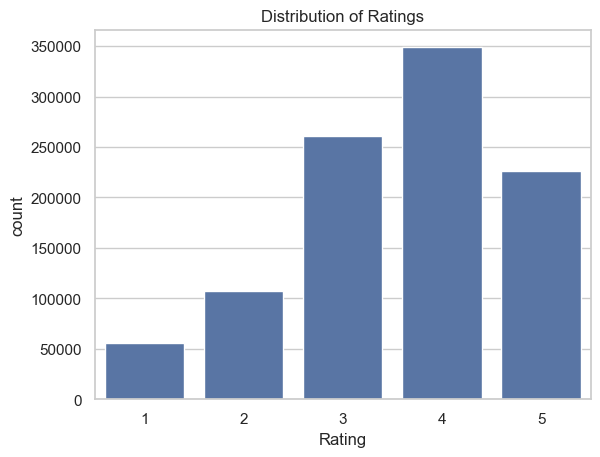

In [23]:
sns.countplot(data=combined, x="Rating")
plt.title("Distribution of Ratings");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- Above plot shows distribution of ratings given by users.

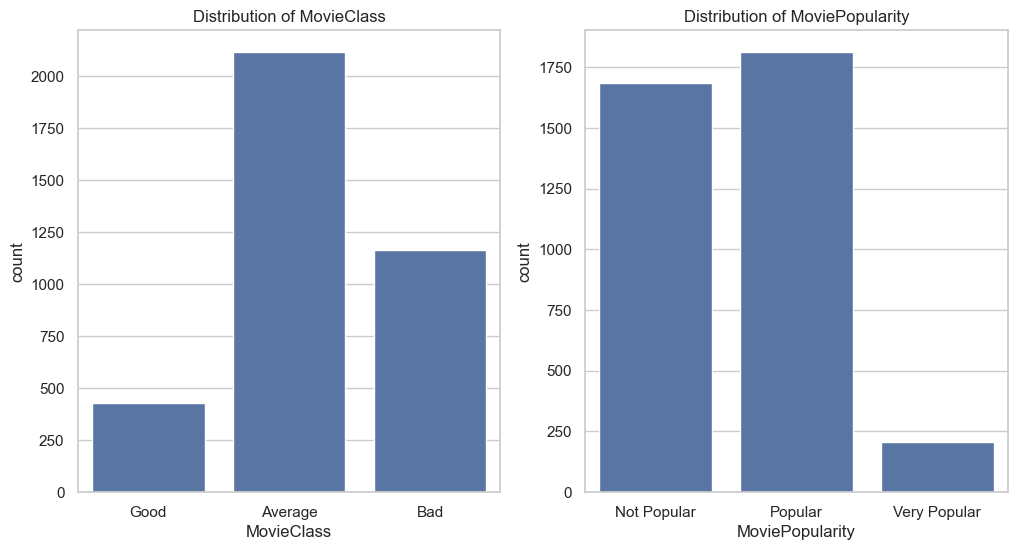

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=combined.select("MovieID", "MovieClass").unique(), x="MovieClass" , ax=ax[0])
ax[0].set_title("Distribution of MovieClass");

sns.countplot(data=combined.select("MovieID", "MoviePopularity").unique(), x="MoviePopularity" , ax=ax[1])
ax[1].set_title("Distribution of MoviePopularity");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that majority of the movies are rated as average
- We can see that majority of the movies are in "Popular" category, but very few in "Very Popular" category.

In [74]:
combined["Title"].value_counts().sort("count",  descending=True).head(10)

Title,count
str,u32
"""American Beauty (1999)""",3428
"""Star Wars: Episode IV - A New …",2991
"""Star Wars: Episode V - The Emp…",2990
"""Star Wars: Episode VI - Return…",2883
"""Jurassic Park (1993)""",2672
"""Saving Private Ryan (1998)""",2653
"""Terminator 2: Judgment Day (19…",2649
"""Matrix, The (1999)""",2590
"""Back to the Future (1985)""",2583


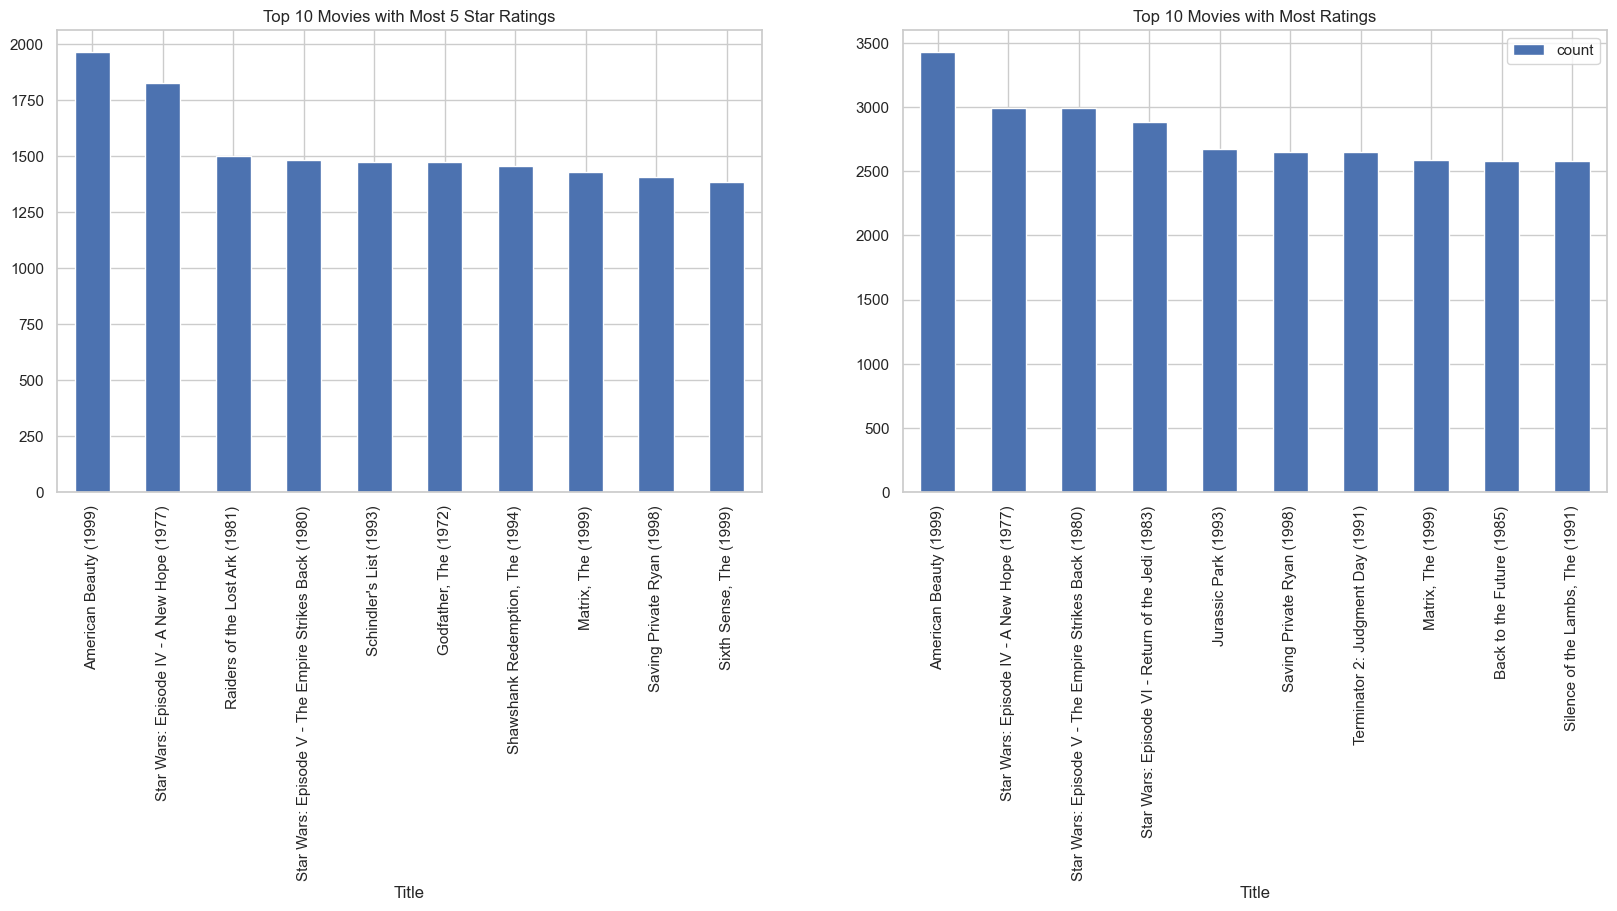

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

combined.filter(pl.col("Rating") == 5).group_by("Title").agg(pl.count("Rating").alias("Count")).sort("Count", descending=True).head(10).to_pandas().plot(kind="bar", x="Title", y="Count", legend=False, ax=ax[0])
ax[0].set_title("Top 10 Movies with Most 5 Star Ratings");

combined["Title"].value_counts().sort("count",  descending=True).head(10).to_pandas().plot(kind="bar", x="Title", y="count", ax=ax[1])
ax[1].set_title("Top 10 Movies with Most Ratings");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- Above plot shows the top 10 5 star rated movies.

In [77]:
users["Gender"].value_counts()

Gender,count
str,u32
"""F""",1709
"""M""",4331


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that there are more Male users then Female users

In [228]:
combined["Gender"].value_counts(normalize=True)

Gender,proportion
str,f64
"""F""",0.246389
"""M""",0.753611


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that majority of ratings are given by male users.

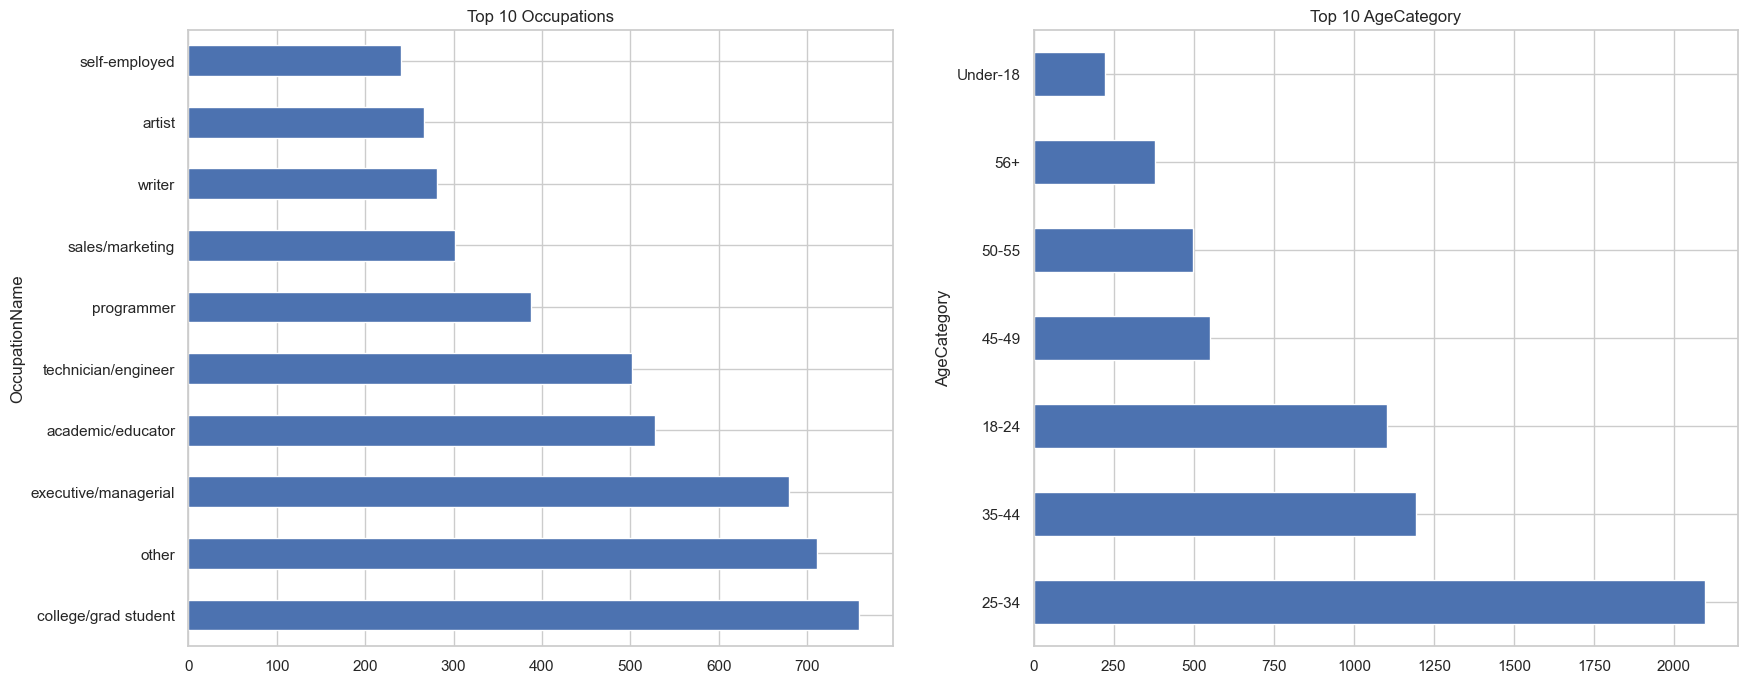

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
users["OccupationName"].value_counts().sort("count", descending=True).head(10).to_pandas().plot(kind="barh", x="OccupationName", y="count", legend=False, ax=ax[0] );
ax[0].set_title("Top 10 Occupations");
users["AgeCategory"].value_counts().sort("count", descending=True).head(10).to_pandas().plot(kind="barh", x="AgeCategory", y="count", legend=False, ax=ax[1] );
ax[1].set_title("Top 10 AgeCategory");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that most of the users are from College/Grad students category
- we can also see that most of the users belong to  25-34 age group

Examine user demographics and their
potential influence on movie
preferences

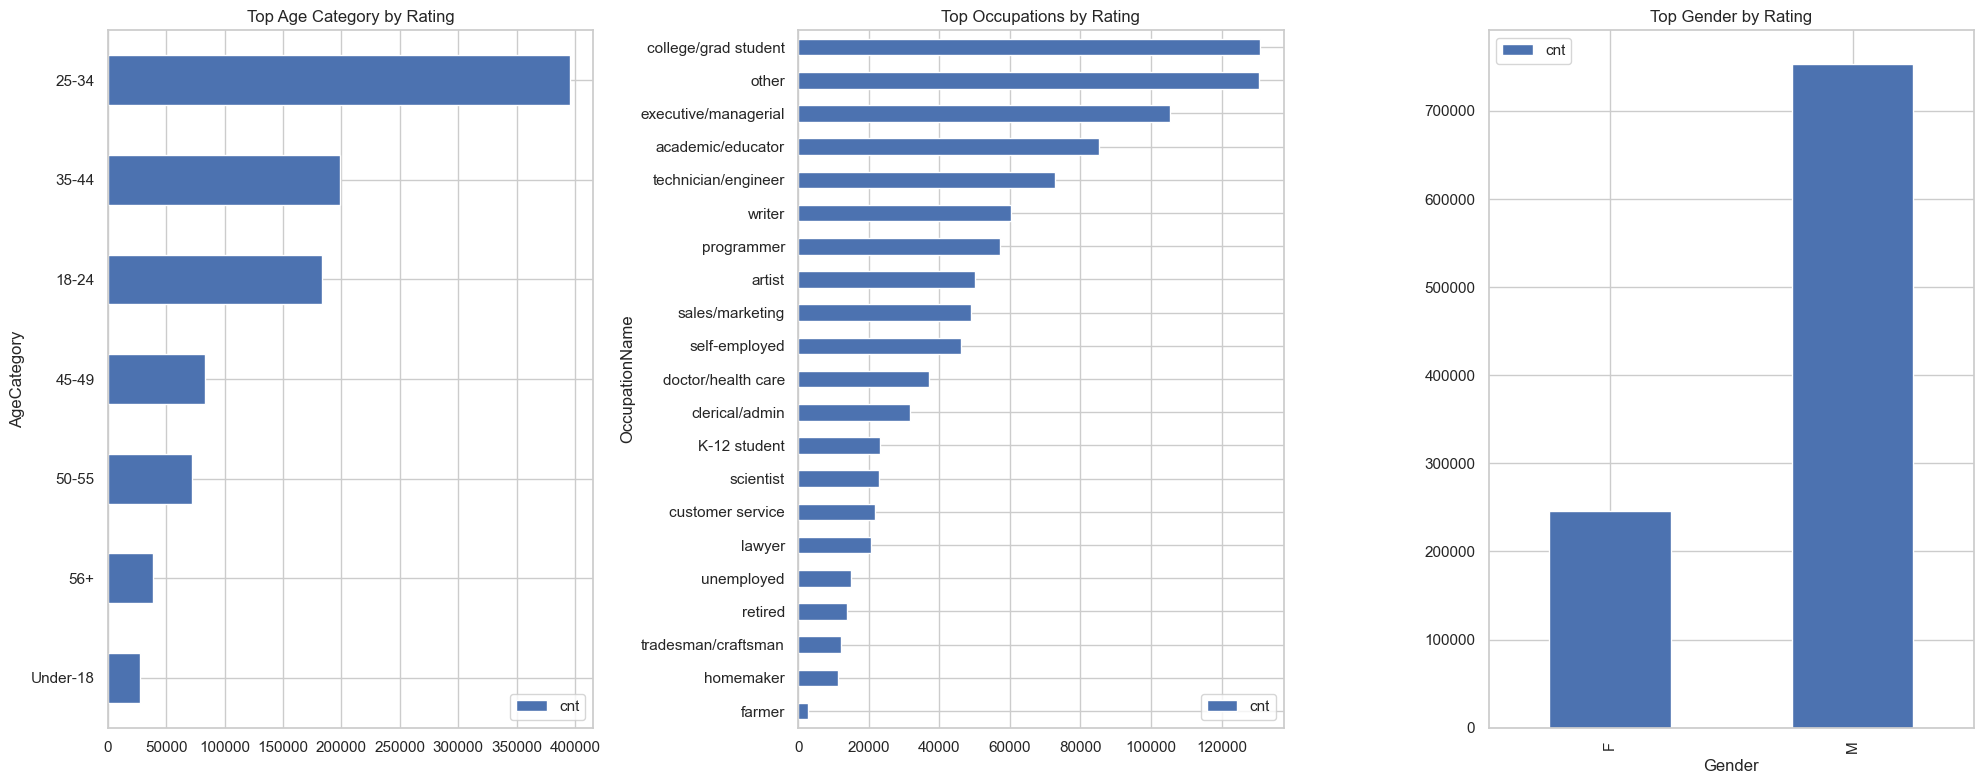

In [79]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

db.sql("""
select AgeCategory, count(*) cnt from combined group by AgeCategory order by cnt 
""").to_df().plot(kind="barh", x="AgeCategory", y="cnt", ax=ax[0] );
ax[0].set_title("Top Age Category by Rating");

db.sql("""
select OccupationName, count(*) cnt from combined group by OccupationName order by cnt 
""").to_df().plot(kind="barh", x="OccupationName", y="cnt", ax=ax[1] );
ax[1].set_title("Top Occupations by Rating");

db.sql("""
select Gender, count(*) cnt from combined group by Gender order by cnt 
""").to_df().plot(kind="bar", x="Gender", y="cnt", ax=ax[2] );
ax[2].set_title("Top Gender by Rating");
plt.tight_layout()

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that users with ages between 25-35 have rated the highest movies
- We can see that college/grad students have highest rated movies
- Most the users who have rated the movies are male

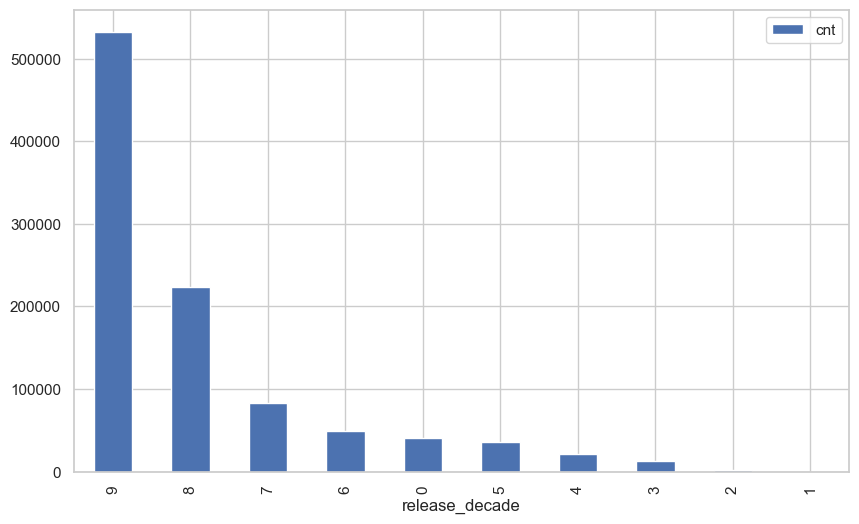

In [ ]:
db.sql("""
       select 
       substring(ReleaseYear, 3,1) release_decade,
       count(*) cnt from movies 
       group by release_decade order by cnt desc""").to_df().plot(kind="bar", x="release_decade", y="cnt", figsize=(10, 6));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that most odf the movies were released in 90's decade

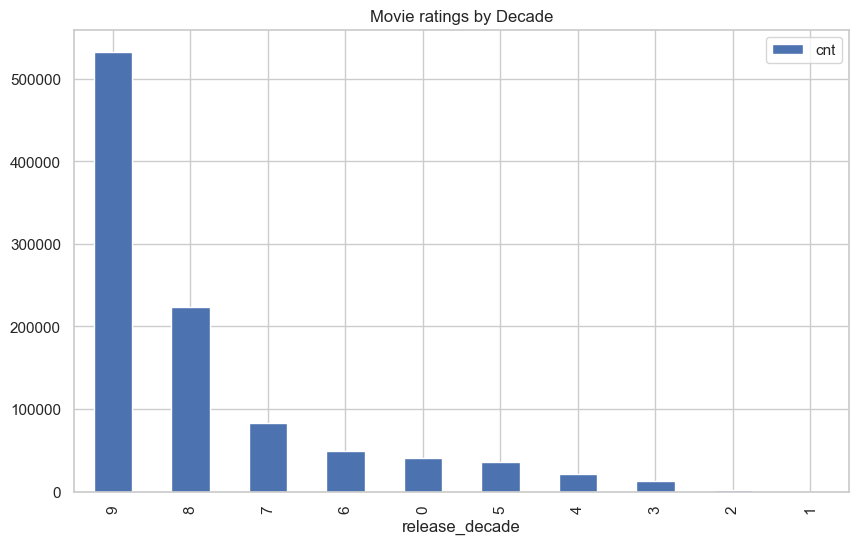

In [232]:
db.sql("""
       select 
       substring(ReleaseYear, 3,1) release_decade,
       count(*) cnt from combined 
       group by release_decade order by cnt desc""").to_df().plot(kind="bar", x="release_decade", y="cnt", figsize=(10, 6));
plt.title("Movie ratings by Decade");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that people have rated movies from from 90's decade the most

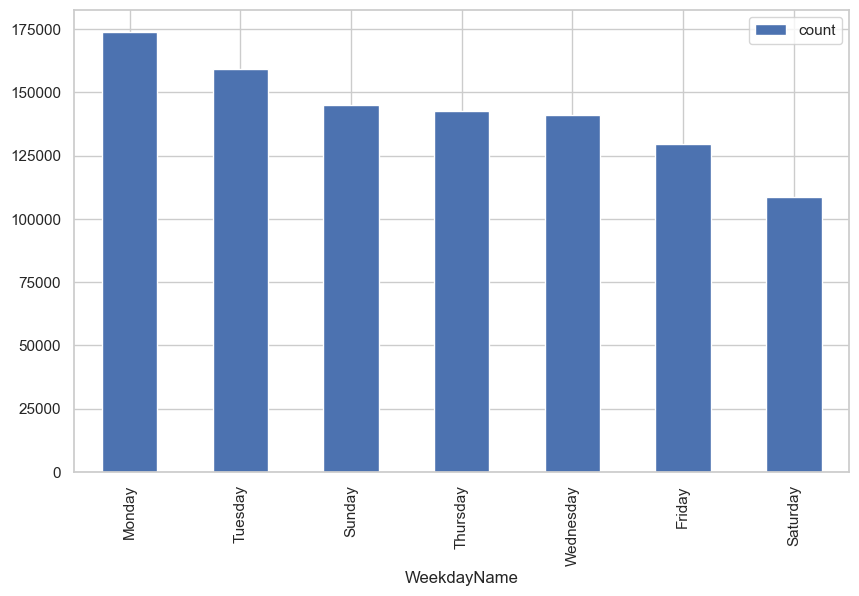

In [17]:
combined["WeekdayName"].value_counts().sort("count",  descending=True).to_pandas().plot(kind="bar", x="WeekdayName", y="count", figsize=(10, 6));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that most of the ratings are given on Monday

In [229]:
combined

UserID,MovieID,Rating,Timestamp,Title,Genres,ReleaseYear,Year,Month,Day,Weekday,Hour,WeekdayName,IsWeekend,AvgMovieRating,TotalMovieRatings,AvgUserRating,TotalUserRatings,WeightedAverageMovieRating,Gender,Age,ZipCode,OccupationName,AgeCategory,MovieClass,MoviePopularity
i64,i64,i64,datetime[μs],str,str,str,i32,i8,i8,i8,i8,str,bool,f64,i64,f64,i64,f64,str,i64,str,str,str,str,str
4,1097,4,2000-12-31 20:19:24,"""E.T. the Extra-Terrestrial (19…","""Children's|Drama|Fantasy|Sci-F…","""1982""",2000,12,31,7,20,"""Sunday""",true,3.965,2269,4.19,21,3.945371,"""M""",45,"""02460""","""executive/managerial""","""45-49""","""Average""","""Very Popular"""
4,2951,4,2000-12-31 20:24:42,"""Fistful of Dollars, A (1964)""","""Action|Western""","""1964""",2000,12,31,7,20,"""Sunday""",true,3.994,522,4.19,21,3.914579,"""M""",45,"""02460""","""executive/managerial""","""45-49""","""Average""","""Popular"""
4,3418,4,2000-12-31 20:24:20,"""Thelma & Louise (1991)""","""Action|Drama""","""1991""",2000,12,31,7,20,"""Sunday""",true,3.68,1417,4.19,21,3.668134,"""M""",45,"""02460""","""executive/managerial""","""45-49""","""Average""","""Very Popular"""
4,2366,4,2000-12-31 20:23:50,"""King Kong (1933)""","""Action|Adventure|Horror""","""1933""",2000,12,31,7,20,"""Sunday""",true,3.656,756,4.19,21,3.637776,"""M""",45,"""02460""","""executive/managerial""","""45-49""","""Average""","""Popular"""
4,1198,5,2000-12-31 20:23:19,"""Raiders of the Lost Ark (1981)""","""Action|Adventure""","""1981""",2000,12,31,7,20,"""Sunday""",true,4.478,2514,4.19,21,4.440586,"""M""",45,"""02460""","""executive/managerial""","""45-49""","""Good""","""Very Popular"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6038,1223,5,2000-04-26 00:08:54,"""Grand Day Out, A (1992)""","""Animation|Comedy""","""1992""",2000,4,26,3,0,"""Wednesday""",false,4.362,473,3.8,20,4.211564,"""F""",56,"""14706""","""academic/educator""","""56+""","""Good""","""Popular"""
6038,1276,3,2000-04-26 00:06:44,"""Cool Hand Luke (1967)""","""Comedy|Drama""","""1967""",2000,4,26,3,0,"""Wednesday""",false,4.254,930,3.8,20,4.180796,"""F""",56,"""14706""","""academic/educator""","""56+""","""Good""","""Popular"""
6038,1387,2,2000-04-25 23:56:45,"""Jaws (1975)""","""Action|Horror""","""1975""",2000,4,25,2,23,"""Tuesday""",false,4.09,1697,3.8,20,4.057168,"""F""",56,"""14706""","""academic/educator""","""56+""","""Good""","""Very Popular"""


https://builtin.com/data-science/recommender-systems

# Pearson Correlation Recommender

## Item-Item Similarity Based Collaborative Filtering

In [184]:
movies = pd.read_parquet("../data/processed/movies.parquet")
ratings = pd.read_parquet("../data/processed/ratings.parquet", engine ='fastparquet')
users = pd.read_parquet("../data/processed/users.parquet")

**Pivot Table**

In [185]:
rating_pivot = ratings.pivot_table(values="Rating", index="UserID", columns="MovieID").fillna(0)
rating_pivot.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Correlation Matrix**

In [186]:
movie_corr = rating_pivot.corr()
movie_corr.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.262649,0.146536,0.109375,0.170156,0.168087,0.189333,0.082963,0.045705,0.215653,...,0.039913,0.002483,0.054038,0.018530,-0.007335,0.132009,0.076941,0.050559,-0.002849,0.052121
2,0.262649,1.000000,0.169586,0.111616,0.196561,0.137334,0.193658,0.173878,0.126871,0.302042,...,0.025345,0.004734,0.055814,0.061466,0.047608,0.108027,0.075658,0.060941,0.000489,0.045883
3,0.146536,0.169586,1.000000,0.158659,0.268062,0.095834,0.238816,0.068058,0.100622,0.164252,...,0.007877,0.058906,0.032291,0.059063,0.028135,0.104775,0.050016,0.039715,-0.011203,0.034831
4,0.109375,0.111616,0.158659,1.000000,0.247529,0.071081,0.187311,0.034228,0.042133,0.082035,...,0.037847,0.048747,-0.008854,0.007128,0.011165,0.067022,0.064363,0.008411,0.012596,0.058965
5,0.170156,0.196561,0.268062,0.247529,1.000000,0.075012,0.264749,0.076378,0.116465,0.176002,...,0.002233,0.078781,0.032615,0.023873,-0.002865,0.107924,0.048976,0.033442,-0.005872,0.064648


In [82]:
with open("../models/movie_corr.pkl", "wb") as f:
    pickle.dump(movie_corr, f)

In [2]:
with open("../models/movie_corr.pkl", "rb") as f:
    movie_corr = pickle.load(f)

### Recommendation based only on movie id

In [187]:
movies

,MovieID,Title,Genres,ReleaseYear
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000
3879,3949,Requiem for a Dream (2000),Drama,2000
3880,3950,Tigerland (2000),Drama,2000
3881,3951,Two Family House (2000),Drama,2000


In [108]:
random_movie = movies.sample(1)
random_movie_id = random_movie["MovieID"].values[0]
random_movie

,MovieID,Title,Genres,ReleaseYear
1736,1796,In God's Hands (1998),Action|Drama,1998


In [112]:
top_n_movies=movie_corr.loc[648].sort_values(ascending=False)
top_n_movies = top_n_movies[top_n_movies.index != random_movie_id]
top_n_movies=top_n_movies[:10]
top_n_movies

MovieID
648     1.000000
380     0.492173
733     0.487349
10      0.468448
1552    0.465473
1370    0.456723
1377    0.448973
349     0.448161
165     0.442651
1608    0.441444
Name: 648, dtype: float64

In [113]:
pd.DataFrame(top_n_movies.index).merge(movies, on="MovieID")

,MovieID,Title,Genres,ReleaseYear
0,648,Mission: Impossible (1996),Action|Adventure|Mystery,1996
1,380,True Lies (1994),Action|Adventure|Comedy|Romance,1994
2,733,"Rock, The (1996)",Action|Adventure|Thriller,1996
3,10,GoldenEye (1995),Action|Adventure|Thriller,1995
4,1552,Con Air (1997),Action|Adventure|Thriller,1997
5,1370,Die Hard 2 (1990),Action|Thriller,1990
6,1377,Batman Returns (1992),Action|Adventure|Comedy|Crime,1992
7,349,Clear and Present Danger (1994),Action|Adventure|Thriller,1994
8,165,Die Hard: With a Vengeance (1995),Action|Thriller,1995
9,1608,Air Force One (1997),Action|Thriller,1997


**Combining above code into a function**

In [190]:
def recommend_movies_by_movie_id(movie_id, n=5):
    print(f"Recommendation for movie: {movies[movies['MovieID'] == movie_id]['Title'].values[0]}")
    top_n_movies=movie_corr.loc[movie_id].sort_values(ascending=False)
    top_n_movies = top_n_movies[top_n_movies.index != movie_id]
    top_n_movies=top_n_movies[:n]
    return pd.DataFrame(top_n_movies.index).merge(movies, on="MovieID")

In [189]:
recommend_movies_by_movie_id(1485)

Recommendation for movie: Liar Liar (1997)


,MovieID,Title,Genres,ReleaseYear
0,500,Mrs. Doubtfire (1993),Comedy,1993
1,231,Dumb & Dumber (1994),Comedy,1994
2,344,Ace Ventura: Pet Detective (1994),Comedy,1994
3,586,Home Alone (1990),Children's|Comedy,1990
4,1777,"Wedding Singer, The (1998)",Comedy|Romance,1998
5,3253,Wayne's World (1992),Comedy,1992
6,784,"Cable Guy, The (1996)",Comedy,1996
7,333,Tommy Boy (1995),Comedy,1995
8,1517,Austin Powers: International Man of Mystery (1...,Comedy,1997
9,585,"Brady Bunch Movie, The (1995)",Comedy,1995


### Recommendation based user id

This will recommend movies to a user based on the movies that the user has already watched. It will only recommend movies that have a high correlation with the movies that the user has rated highly.

In [89]:
# source chatgpt
def calculate_dynamic_threshold(similarity_row):
    """
    Calculates a dynamic threshold based on the similarity distribution for a movie.
    Ignores NaN and negative values, and uses the 25th percentile as the threshold.

    Args:
        similarity_row (np.ndarray): Row of similarity scores for a movie.

    Returns:
        float: Dynamic threshold for the movie.
    """
    valid_similarities = similarity_row[~np.isnan(similarity_row) & (similarity_row > 0)]
    if len(valid_similarities) == 0:
        return 0  # No valid similarities, set threshold to 0
    return np.percentile(valid_similarities, 25)  # 25th percentile

In [142]:
def recommend_movies_by_user_id(user_id, n=10):
    user_rated_movies = rating_pivot.loc[user_id][rating_pivot.loc[user_id] > 0].index
    movie_ratings = rating_pivot.loc[user_id].to_dict()
    unrated_movies = rating_pivot.loc[user_id][rating_pivot.loc[user_id] == 0].index

    similarity_score={}
    for movie_id in unrated_movies:
        numerator = 0
        denominator = 0
        threshold = calculate_dynamic_threshold(movie_corr[movie_id])
        for rated_movie in user_rated_movies:
            sim=movie_corr.loc[movie_id, rated_movie]
            if sim > threshold:
                numerator += sim * movie_ratings[rated_movie]
                denominator += abs(sim)
        similarity_score[movie_id] = numerator / denominator if denominator != 0 else 0
    return pd.DataFrame(similarity_score.items(), columns=["MovieID", "PredictedRating"]).sort_values("PredictedRating", ascending=False).merge(movies, on="MovieID").head(10)

In [143]:
recommend_movies_by_user_id(1)

,MovieID,PredictedRating,Title,Genres,ReleaseYear
0,1915,5.000000,Voyage to the Beginning of the World (1997),Drama,1997
1,3216,4.751446,Vampyros Lesbos (Las Vampiras) (1970),Horror,1970
2,3621,4.671628,Possession (1981),Drama|Horror,1981
3,878,4.591584,Bye-Bye (1995),Drama,1995
4,1433,4.581080,"Machine, The (1994)",Comedy|Horror,1994
5,2740,4.550616,"Kindred, The (1986)",Horror,1986
6,1787,4.549433,Paralyzing Fear: The Story of Polio in America...,Documentary,1998
7,989,4.533011,Schlafes Bruder (Brother of Sleep) (1995),Drama,1995
8,3881,4.532808,Bittersweet Motel (2000),Documentary,2000
9,3123,4.528056,Spring Fever USA (a.k.a. Lauderdale) (1989),Comedy,1989


# Cosine Similarity

## Item-Item Similarity Based Collaborative Filtering

In [191]:
movies = pl.read_parquet('../data/processed/movies.parquet')
ratings = pd.read_parquet('../data/processed/ratings.parquet', engine='fastparquet')
users = pd.read_parquet("../data/processed/users.parquet")

**Pivot Table**

In [192]:
rating_pivot = ratings.pivot_table(values="Rating", index="MovieID", columns="UserID").fillna(0)
rating_pivot.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
MovieID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


**Ratings based similarity matrix**

In [193]:
cos_similarity = cosine_similarity(rating_pivot)
rating_based_movie_similarity_df = pd.DataFrame(cos_similarity, index=rating_pivot.index, columns=rating_pivot.index)
rating_based_movie_similarity_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.390349,0.267943,0.178789,0.256569,0.347373,0.301490,0.125709,0.106620,0.377459,...,0.099502,0.020966,0.084105,0.081826,0.045949,0.309676,0.186633,0.093479,0.042829,0.182691
2,0.390349,1.000000,0.240946,0.155457,0.249970,0.244827,0.262772,0.196521,0.158469,0.386200,...,0.061819,0.015209,0.075310,0.095573,0.074271,0.213650,0.140781,0.087013,0.026063,0.122185
3,0.267943,0.240946,1.000000,0.192788,0.308290,0.187020,0.292230,0.092122,0.128378,0.245601,...,0.038492,0.065507,0.049512,0.087377,0.050985,0.190575,0.104837,0.062258,0.010073,0.097786
4,0.178789,0.155457,0.192788,1.000000,0.271990,0.125170,0.220024,0.049554,0.060334,0.133707,...,0.055486,0.053300,0.002227,0.025278,0.025204,0.118902,0.096318,0.022588,0.024769,0.095154
5,0.256569,0.249970,0.308290,0.271990,1.000000,0.148114,0.305107,0.095512,0.138392,0.237681,...,0.026632,0.083898,0.046399,0.047542,0.016156,0.174554,0.092403,0.051633,0.010750,0.112835


In [194]:
ratings.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,ReleaseYear,Year,Month,Day,Weekday,Hour,WeekdayName,IsWeekend,AvgMovieRating,TotalMovieRatings,AvgUserRating,TotalUserRatings,WeightedAverageMovieRating
0,4,1097,4,2000-12-31 20:19:24,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,1982,2000,12,31,7,20,Sunday,True,3.965,2269,4.19,21,3.945371
1,4,2951,4,2000-12-31 20:24:42,"Fistful of Dollars, A (1964)",Action|Western,1964,2000,12,31,7,20,Sunday,True,3.994,522,4.19,21,3.914579
2,4,3418,4,2000-12-31 20:24:20,Thelma & Louise (1991),Action|Drama,1991,2000,12,31,7,20,Sunday,True,3.680,1417,4.19,21,3.668134
3,4,2366,4,2000-12-31 20:23:50,King Kong (1933),Action|Adventure|Horror,1933,2000,12,31,7,20,Sunday,True,3.656,756,4.19,21,3.637776
4,4,1198,5,2000-12-31 20:23:19,Raiders of the Lost Ark (1981),Action|Adventure,1981,2000,12,31,7,20,Sunday,True,4.478,2514,4.19,21,4.440586


In [195]:
ratings=ratings[["MovieID", "AvgMovieRating", "TotalMovieRatings"]].drop_duplicates()
ratings.shape

(3706, 3)

In [196]:
movies.head()

MovieID,Title,Genres,ReleaseYear
i64,str,str,str
1,"""Toy Story (1995)""","""Animation|Children's|Comedy""","""1995"""
2,"""Jumanji (1995)""","""Adventure|Children's|Fantasy""","""1995"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance""","""1995"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama""","""1995"""
5,"""Father of the Bride Part II (1…","""Comedy""","""1995"""


In [197]:
movies=movies.with_columns(
    pl.col("Genres").str.split("|").alias("Genres")
).explode("Genres").to_pandas()
movies.head()

,MovieID,Title,Genres,ReleaseYear
0,1,Toy Story (1995),Animation,1995
1,1,Toy Story (1995),Children's,1995
2,1,Toy Story (1995),Comedy,1995
3,2,Jumanji (1995),Adventure,1995
4,2,Jumanji (1995),Children's,1995


In [198]:
movies_pivot = movies.pivot_table(index="MovieID", columns="Genres", aggfunc='size', fill_value=0)
movies_pivot

Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3949,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [199]:
movies_pivot=movies_pivot.reset_index()

In [200]:
movies_df=movies_pivot.merge(ratings, on="MovieID", how="left").fillna(0)
movies_df = movies_df.set_index("MovieID")
movies_df.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,AvgMovieRating,TotalMovieRatings
MovieID,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.147,2077.0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.201,701.0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3.017,478.0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2.729,170.0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.007,296.0


In [201]:
sc=StandardScaler()
movies_df_scaled=sc.fit_transform(movies_df)
movies_df_scaled

array([[-0.38576751, -0.28037673,  5.99841249, ..., -0.13350797,
         1.12006327,  4.79623255],
       [-0.38576751,  3.56662979, -0.16671078, ..., -0.13350797,
         0.11643486,  1.16890068],
       [-0.38576751, -0.28037673, -0.16671078, ..., -0.13350797,
        -0.07877405,  0.58104094],
       ...,
       [-0.38576751, -0.28037673, -0.16671078, ..., -0.13350797,
         0.61082264, -0.53668342],
       [-0.38576751, -0.28037673, -0.16671078, ..., -0.13350797,
         0.85801653, -0.57358941],
       [-0.38576751, -0.28037673, -0.16671078, ..., -0.13350797,
         0.73176729,  0.34378813]])

In [202]:
movies_df_scaled=pd.DataFrame(movies_df_scaled, columns=movies_df.columns, index=movies_df.index)

In [203]:
movies_df_scaled.to_parquet("../data/processed/movies_df_scaled.parquet")

**Movies features based similarity matrix**

In [204]:
cos_similarity_matrix = cosine_similarity(movies_df_scaled)
features_based_movie_similarity_df = pd.DataFrame(cos_similarity_matrix , index=movies_pivot["MovieID"], columns=movies_pivot["MovieID"])

In [205]:
features_based_movie_similarity_df

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.214883,0.114197,-0.070673,0.126977,0.089959,0.121087,0.218764,-0.187190,0.075936,...,-0.012860,-0.188402,0.619093,-0.227593,-0.170745,0.438119,-0.071367,-0.297797,-0.276489,-0.061829
2,0.214883,1.000000,-0.092706,-0.217185,-0.126030,-0.038100,-0.092920,0.546101,-0.095381,0.239267,...,-0.155741,-0.217542,0.341691,-0.144834,-0.095539,-0.021251,-0.129380,-0.185864,-0.176879,-0.112546
3,0.114197,-0.092706,1.000000,0.135416,0.428231,-0.136309,0.992276,-0.155519,-0.173579,-0.152016,...,0.374468,0.097010,-0.135699,-0.328026,-0.184498,0.418960,-0.313237,-0.390295,-0.375893,-0.288543
4,-0.070673,-0.217185,0.135416,1.000000,0.514122,-0.378870,0.115308,-0.249094,-0.279179,-0.399782,...,0.526790,0.951543,-0.184879,-0.046030,-0.319962,0.288021,0.222536,0.319213,0.282743,-0.009541
5,0.126977,-0.126030,0.428231,0.514122,1.000000,-0.208928,0.420986,-0.136069,-0.071495,-0.227369,...,0.965647,0.459594,-0.143302,-0.392635,-0.084687,0.780391,-0.265488,-0.291218,-0.282444,-0.337866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.438119,-0.021251,0.418960,0.288021,0.780391,0.045243,0.435800,-0.160179,-0.171070,0.018524,...,0.611824,0.093331,-0.200913,-0.411170,-0.130462,1.000000,-0.030609,-0.302047,-0.269999,-0.138255
3949,-0.071367,-0.129380,-0.313237,0.222536,-0.265488,-0.143745,-0.247259,-0.167237,-0.202703,-0.194180,...,-0.263223,0.045474,-0.277147,-0.049866,-0.049751,-0.030609,1.000000,0.915673,0.933331,0.397815
3950,-0.297797,-0.185864,-0.390295,0.319213,-0.291218,-0.292791,-0.345050,-0.143393,-0.131373,-0.334119,...,-0.203880,0.246525,-0.221407,0.035355,-0.025689,-0.302047,0.915673,1.000000,0.993111,0.331591


In [206]:
user_rating_pivot=rating_pivot.T
user_rating_pivot

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**User Ratings based similarity matrix**

In [207]:
cos_similarity_matrix = cosine_similarity(user_rating_pivot)
user_rating_based_similarity_df = pd.DataFrame(cos_similarity_matrix, index=user_rating_pivot.index, columns=user_rating_pivot.index)
user_rating_based_similarity_df

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.255288,...,0.170588,0.082006,0.069807,0.033663,0.114877,0.186329,0.135979,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.203337,0.190198,0.226861,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.228241,0.206274,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.213655,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143264,0.107744,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.120738,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.170583,0.127464,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117052,...,0.100652,0.035732,0.061806,0.054151,0.179083,0.293365,0.172686,0.020459,0.027689,0.241437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.186329,0.228241,0.143264,0.170583,0.293365,0.093583,0.122441,0.227400,0.239607,0.338072,...,0.131294,0.209843,0.186426,0.103431,0.267405,1.000000,0.341462,0.124174,0.219115,0.411891
6037,0.135979,0.206274,0.107744,0.127464,0.172686,0.065788,0.111673,0.144395,0.225055,0.246902,...,0.142309,0.276134,0.129985,0.118749,0.141676,0.341462,1.000000,0.049015,0.252146,0.428240
6038,0.000000,0.066118,0.120234,0.062907,0.020459,0.065711,0.000000,0.019242,0.093470,0.113789,...,0.108837,0.106897,0.040689,0.000000,0.063967,0.124174,0.049015,1.000000,0.161714,0.099300


In [208]:
users=users.drop([ "AgeCategory"], axis=1)

In [209]:
users["Gender"]=users["Gender"].map({
    "M":1,
    "F":0
})

In [210]:
users["ZipCode"]=users["ZipCode"].astype(str).str.extract(r"(\d{1})").astype(int)

In [211]:
users.head()

,UserID,Gender,Age,ZipCode,OccupationName
0,1,0,1,4,K-12 student
1,2,1,56,7,self-employed
2,3,1,25,5,scientist
3,4,1,45,0,executive/managerial
4,5,1,25,5,writer


In [212]:
users

,UserID,Gender,Age,ZipCode,OccupationName
0,1,0,1,4,K-12 student
1,2,1,56,7,self-employed
2,3,1,25,5,scientist
3,4,1,45,0,executive/managerial
4,5,1,25,5,writer
...,...,...,...,...,...
6035,6036,0,25,3,scientist
6036,6037,0,45,7,academic/educator
6037,6038,0,56,1,academic/educator
6038,6039,0,45,0,other


In [213]:
encoder = OneHotEncoder(sparse_output=False)
occupation_one_hot = encoder.fit_transform(users["OccupationName"].values.reshape(-1, 1))
occupation_one_hot_df = pd.DataFrame(occupation_one_hot, columns=encoder.get_feature_names_out(["Occupation"]))
occupation_one_hot_df.head()

,Occupation_K-12 student,Occupation_academic/educator,Occupation_artist,Occupation_clerical/admin,Occupation_college/grad student,Occupation_customer service,Occupation_doctor/health care,Occupation_executive/managerial,Occupation_farmer,Occupation_homemaker,...,Occupation_other,Occupation_programmer,Occupation_retired,Occupation_sales/marketing,Occupation_scientist,Occupation_self-employed,Occupation_technician/engineer,Occupation_tradesman/craftsman,Occupation_unemployed,Occupation_writer
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [214]:
encoder = OneHotEncoder(sparse_output=False)
zipCode_one_hot = encoder.fit_transform(users["ZipCode"].values.reshape(-1, 1))
zipCode_one_hot_df = pd.DataFrame(zipCode_one_hot, columns=encoder.get_feature_names_out(["ZipCode"]))
zipCode_one_hot_df.head()

,ZipCode_0,ZipCode_1,ZipCode_2,ZipCode_3,ZipCode_4,ZipCode_5,ZipCode_6,ZipCode_7,ZipCode_8,ZipCode_9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [215]:
users = pd.concat([users, occupation_one_hot_df, zipCode_one_hot_df], axis=1)
users = users.drop(["OccupationName", "ZipCode"], axis=1)
users.head()

,UserID,Gender,Age,Occupation_K-12 student,Occupation_academic/educator,Occupation_artist,Occupation_clerical/admin,Occupation_college/grad student,Occupation_customer service,Occupation_doctor/health care,...,ZipCode_0,ZipCode_1,ZipCode_2,ZipCode_3,ZipCode_4,ZipCode_5,ZipCode_6,ZipCode_7,ZipCode_8,ZipCode_9
0,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [216]:
users=users.set_index("UserID")

In [217]:
users

,Gender,Age,Occupation_K-12 student,Occupation_academic/educator,Occupation_artist,Occupation_clerical/admin,Occupation_college/grad student,Occupation_customer service,Occupation_doctor/health care,Occupation_executive/managerial,...,ZipCode_0,ZipCode_1,ZipCode_2,ZipCode_3,ZipCode_4,ZipCode_5,ZipCode_6,ZipCode_7,ZipCode_8,ZipCode_9
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0,45,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6038,0,56,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
sc = StandardScaler()
users_scaled = sc.fit_transform(users)
users_scaled = pd.DataFrame(users_scaled, columns=users.columns)
users_scaled.head()

,Gender,Age,Occupation_K-12 student,Occupation_academic/educator,Occupation_artist,Occupation_clerical/admin,Occupation_college/grad student,Occupation_customer service,Occupation_doctor/health care,Occupation_executive/managerial,...,ZipCode_0,ZipCode_1,ZipCode_2,ZipCode_3,ZipCode_4,ZipCode_5,ZipCode_6,ZipCode_7,ZipCode_8,ZipCode_9
0,-1.591927,-2.298525,5.474884,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,2.991751,-0.349954,-0.276855,-0.273024,-0.231011,-0.566644
1,0.628170,1.966729,-0.182652,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,-0.334252,-0.349954,-0.276855,3.662687,-0.231011,-0.566644
2,0.628170,-0.437323,-0.182652,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,-0.334252,2.857517,-0.276855,-0.273024,-0.231011,-0.566644
3,0.628170,1.113678,-0.182652,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,2.809882,...,2.850240,-0.350848,-0.280649,-0.261286,-0.334252,-0.349954,-0.276855,-0.273024,-0.231011,-0.566644
4,0.628170,-0.437323,-0.182652,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,-0.334252,2.857517,-0.276855,-0.273024,-0.231011,-0.566644


In [220]:
users_scaled["UserID"] = users.index
users_scaled=users_scaled.set_index("UserID")

In [221]:
users_scaled

,Gender,Age,Occupation_K-12 student,Occupation_academic/educator,Occupation_artist,Occupation_clerical/admin,Occupation_college/grad student,Occupation_customer service,Occupation_doctor/health care,Occupation_executive/managerial,...,ZipCode_0,ZipCode_1,ZipCode_2,ZipCode_3,ZipCode_4,ZipCode_5,ZipCode_6,ZipCode_7,ZipCode_8,ZipCode_9
UserID,,,,,,,,,,,,,,,,,,,,,
1,-1.591927,-2.298525,5.474884,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,2.991751,-0.349954,-0.276855,-0.273024,-0.231011,-0.566644
2,0.628170,1.966729,-0.182652,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,-0.334252,-0.349954,-0.276855,3.662687,-0.231011,-0.566644
3,0.628170,-0.437323,-0.182652,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,-0.334252,2.857517,-0.276855,-0.273024,-0.231011,-0.566644
4,0.628170,1.113678,-0.182652,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,2.809882,...,2.850240,-0.350848,-0.280649,-0.261286,-0.334252,-0.349954,-0.276855,-0.273024,-0.231011,-0.566644
5,0.628170,-0.437323,-0.182652,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,-0.334252,2.857517,-0.276855,-0.273024,-0.231011,-0.566644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-1.591927,-0.437323,-0.182652,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,3.827227,-0.334252,-0.349954,-0.276855,-0.273024,-0.231011,-0.566644
6037,-1.591927,1.113678,-0.182652,3.231005,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,-0.334252,-0.349954,-0.276855,3.662687,-0.231011,-0.566644
6038,-1.591927,1.966729,-0.182652,3.231005,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,2.850240,-0.280649,-0.261286,-0.334252,-0.349954,-0.276855,-0.273024,-0.231011,-0.566644


In [222]:
users_scaled.to_parquet("../data/processed/users_scaled.parquet")

**User features based similarity matrix**

In [223]:
cos_similarity_matrix = cosine_similarity(users_scaled)

In [224]:
user_feature_based_similarity_df = pd.DataFrame(cos_similarity_matrix, index=users_scaled.index, columns=users_scaled.index)
user_feature_based_similarity_df

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.163047,-0.040782,-0.184655,-0.053070,-0.047508,-0.121693,-0.059596,-0.057325,-0.019182,...,0.418483,-0.184437,-0.119584,-0.065764,0.039036,0.028298,-0.055279,-0.113344,-0.067826,-0.049748
2,-0.163047,1.000000,-0.052300,0.015504,-0.067918,-0.001102,-0.034173,-0.076139,-0.073387,-0.093613,...,-0.162923,0.015508,0.329356,-0.082850,0.326675,-0.074432,0.405378,0.022354,-0.030908,-0.063706
3,-0.040782,-0.052300,1.000000,-0.070649,0.218332,0.102457,-0.056982,-0.041888,-0.040110,-0.113774,...,-0.080931,0.251690,-0.040841,-0.047632,-0.075035,0.717658,-0.090995,-0.106738,-0.109848,-0.034785
4,-0.184655,0.015504,-0.070649,1.000000,-0.091840,-0.037396,0.431679,-0.103045,-0.099220,-0.162331,...,-0.209619,0.477791,-0.001334,-0.112908,-0.154773,-0.104281,-0.080490,-0.045279,0.401055,-0.086118
5,-0.053070,-0.067918,0.218332,-0.091840,1.000000,0.131277,-0.074230,-0.054735,-0.052425,-0.147344,...,-0.105011,0.322702,-0.053087,-0.062135,-0.097312,-0.065198,-0.117823,-0.138108,-0.142211,-0.045467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.028298,-0.074432,0.717658,-0.104281,-0.065198,-0.001686,-0.090273,-0.073024,-0.070461,0.003416,...,0.023645,-0.104151,-0.060101,-0.078865,0.016783,1.000000,0.000476,-0.009940,-0.001837,-0.061176
6037,-0.055279,0.405378,-0.090995,-0.080490,-0.117823,0.043866,0.389955,-0.131766,-0.127371,0.566061,...,-0.028874,-0.080378,0.335466,-0.140523,0.958921,0.000476,1.000000,0.533680,0.062862,-0.110616
6038,-0.113344,0.022354,-0.106738,-0.045279,-0.138108,0.072589,0.419142,0.237665,-0.149318,0.604709,...,-0.066659,-0.045203,-0.003204,-0.163793,0.433644,-0.009940,0.533680,1.000000,0.103484,0.201980


### Recommend movies based on movie id

In [108]:
def recommend_movies_by_movie_id(movie_id, n=10):
    print(f"Recommendation for movie: {movies[movies['MovieID'] == movie_id]['Title'].values[0]}")
    top_n_movies=rating_based_movie_similarity_df.loc[movie_id].sort_values(ascending=False)
    top_n_movies = top_n_movies[top_n_movies.index != movie_id]
    top_n_movies=top_n_movies[:n]
    return pd.DataFrame(top_n_movies.index).merge(movies, on="MovieID")

In [225]:
recommend_movies_by_movie_id(1485, 10)

Recommendation for movie: Liar Liar (1997)


,MovieID,Title,Genres,ReleaseYear
0,500,Mrs. Doubtfire (1993),Comedy,1993
1,231,Dumb & Dumber (1994),Comedy,1994
2,344,Ace Ventura: Pet Detective (1994),Comedy,1994
3,586,Home Alone (1990),Children's,1990
4,586,Home Alone (1990),Comedy,1990
5,1777,"Wedding Singer, The (1998)",Comedy,1998
6,1777,"Wedding Singer, The (1998)",Romance,1998
7,3253,Wayne's World (1992),Comedy,1992
8,784,"Cable Guy, The (1996)",Comedy,1996
9,333,Tommy Boy (1995),Comedy,1995


# Matrix Factorization

In [128]:
from cmfrec import CMF

In [135]:
users_scaled = pd.read_parquet("../data/processed/users_scaled.parquet")
movies_df_scaled = pd.read_parquet("../data/processed/movies_df_scaled.parquet")
ratings = pd.read_parquet("../data/processed/ratings.parquet", engine='fastparquet')
movies_expanded = pd.read_parquet("../data/processed/movies_expanded.parquet")

In [137]:
ratings=ratings[["UserID", "MovieID", "Rating"]]
ratings= ratings.rename(columns={"MovieID":"ItemId", "UserID":"UserId"})
users_scaled=users_scaled.reset_index().rename(columns={"UserID":"UserId"})
movies_df_scaled=movies_df_scaled.reset_index().rename(columns={"MovieID":"ItemId"})

In [138]:
model = CMF(method="als", k=4, lambda_=1e+1)

model.fit(
    X=ratings,
    U=users_scaled,
    I=movies_df_scaled,
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Collective matrix factorization model
(explicit-feedback variant)


In [139]:
predicted_rating = model.predict(user=12, item=1641)
print(f"Predicted rating for user 12 and movie 1642: {predicted_rating}")

Predicted rating for user 12 and movie 1642: 3.654609441757202


**Using MF to create new User and Item embeddings**

In [140]:
new_A = model.A_
new_B = model.B_

new_A.shape, new_B.shape

((6040, 4), (3883, 4))

**Train Test Split**

In [141]:
rating_train, rating_test = train_test_split(ratings, test_size=0.2)

In [142]:
model = CMF(method="als", lambda_=1e+1, n_jobs=-1, k=4)

model.fit(
    X=rating_train,
    U=users_scaled,
    I=movies_df_scaled,
);

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


In [143]:
rating_test["PredictedRating"]=model.predict(user=rating_test["UserId"], item=rating_test["ItemId"])

In [144]:
rmse = np.sqrt(mean_squared_error(rating_test['Rating'], rating_test['PredictedRating']))
mape = mean_absolute_percentage_error(rating_test['Rating'], rating_test['PredictedRating'])
print(f"RMSE: {rmse}, MAPE: {mape}")

RMSE: 0.8633580280856977, MAPE: 0.2643586531079951


**Hyperparameter Tuning**

In [145]:
vals =np.arange(5, 103, 10).tolist()
vals

[5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

In [146]:

rmse_scores_train=[]
mape_scores_train=[]
rmse_scores_test=[]
mape_scores_test=[]

for n in vals:
    print(f"Training model with k={n}")
    model = CMF(method="als", lambda_=1e+1, n_jobs=-1, k=n)

    model.fit(
        X=rating_train,
        U=users_scaled,
        I=movies_df_scaled,
    );


    rating_test["PredictedRating"]=model.predict(user=rating_test["UserId"], item=rating_test["ItemId"])
    rmse = np.sqrt(mean_squared_error(rating_test['Rating'], rating_test['PredictedRating']))
    mape = mean_absolute_percentage_error(rating_test['Rating'], rating_test['PredictedRating'])
    rmse_scores_test.append(rmse)
    mape_scores_test.append(mape)

    rating_train["PredictedRating"]=model.predict(user=rating_train["UserId"], item=rating_train["ItemId"])
    rmse = np.sqrt(mean_squared_error(rating_train['Rating'], rating_train['PredictedRating']))
    mape = mean_absolute_percentage_error(rating_train['Rating'], rating_train['PredictedRating'])

    rmse_scores_train.append(rmse)
    mape_scores_train.append(mape)

    rating_train=rating_train.drop("PredictedRating", axis=1);

Training model with k=5


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Training model with k=15


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Training model with k=25


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Training model with k=35


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Training model with k=45


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Training model with k=55


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Training model with k=65


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Training model with k=75


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Training model with k=85


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Training model with k=95


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


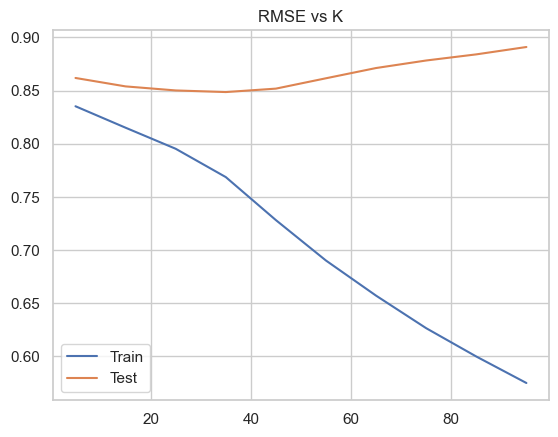

In [147]:
sns.lineplot(x=vals, y=rmse_scores_train, label="Train")
sns.lineplot(x=vals, y=rmse_scores_test, label="Test")
plt.title("RMSE vs K");


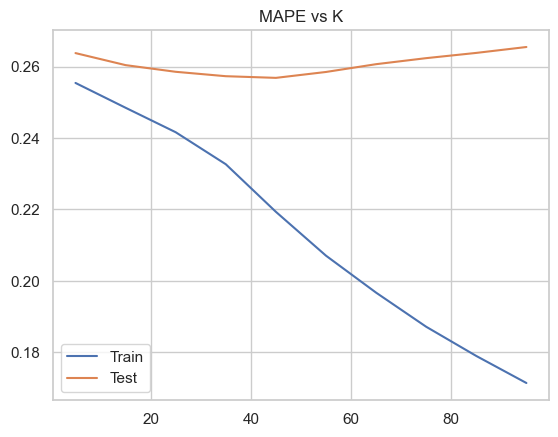

In [148]:
sns.lineplot(x=vals, y=mape_scores_train, label="Train")
sns.lineplot(x=vals, y=mape_scores_test, label="Test")
plt.title("MAPE vs K");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that the RMSE and MAPE is lowest for 40 latent features

**Visualizing the latent features**

In [149]:
model = CMF(method="als", k=2, lambda_=1e+1)

model.fit(
    X=ratings,
    U=users_scaled,
    I=movies_df_scaled,
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Collective matrix factorization model
(explicit-feedback variant)


<Axes: >

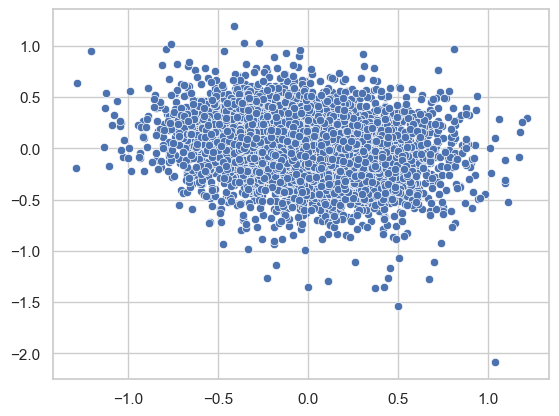

In [150]:
sns.scatterplot(x=model.A_[:, 0], y=model.A_[:, 1])

<Axes: >

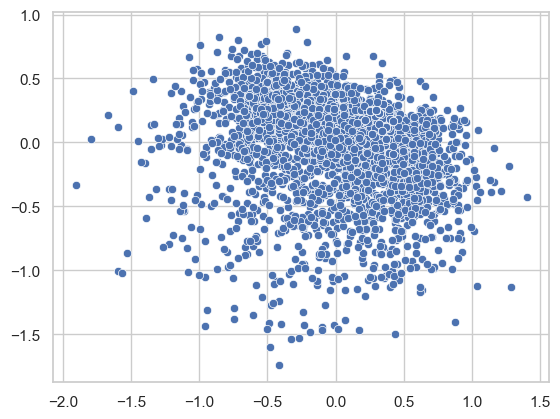

In [151]:
sns.scatterplot(x=model.B_[:, 0], y=model.B_[:, 1])

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plots there is uniform circular distribution of latent features

**Using latent features to recommend movies**

In [152]:
model = CMF(method="als", k=4, lambda_=0.1, n_jobs=-1, user_bias=False, item_bias=False)

model.fit(
    X=ratings,
    U=users_scaled,
    I=movies_df_scaled,
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Collective matrix factorization model
(explicit-feedback variant)


In [153]:
model.A_.shape, model.B_.shape

((6040, 4), (3883, 4))

In [154]:
user_latent = pd.DataFrame(model.A_, index=users_scaled["UserId"])
movie_latent = pd.DataFrame(model.B_, index=movies_df_scaled["ItemId"])

In [ ]:
user_latent_cosine = cosine_similarity(user_latent)
movie_latent_cosine = cosine_similarity(movie_latent)

user_latent_cosine_df = pd.DataFrame(user_latent_cosine, index=user_latent.index, columns=user_latent.index)
movie_latent_cosine_df = pd.DataFrame(movie_latent_cosine, index=movie_latent.index, columns=movie_latent.index)

In [159]:
movie_latent_cosine_df

ItemId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
ItemId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.128640,-0.236907,-0.425389,-0.167614,0.850026,0.133287,-0.192980,-0.513168,0.558419,...,-0.439041,-0.439041,-0.439041,-0.950027,-0.950027,-0.950027,-0.439041,-0.750782,-0.439041,-0.439041
2,0.128640,1.000000,0.928556,0.740851,0.917736,0.046734,0.908123,0.932466,0.683385,0.601534,...,-0.594867,-0.594867,-0.594867,-0.219299,-0.219299,-0.219299,-0.594867,0.188965,-0.594867,-0.594867
3,-0.236907,0.928556,1.000000,0.853322,0.966422,-0.274106,0.848517,0.962935,0.857257,0.406098,...,-0.358777,-0.358777,-0.358777,0.146232,0.146232,0.146232,-0.358777,0.505122,-0.358777,-0.358777
4,-0.425389,0.740851,0.853322,1.000000,0.885579,-0.551441,0.768426,0.905383,0.675786,-0.065902,...,-0.330329,-0.330329,-0.330329,0.201478,0.201478,0.201478,-0.330329,0.513188,-0.330329,-0.330329
5,-0.167614,0.917736,0.966422,0.885579,1.000000,-0.342612,0.941877,0.930159,0.707797,0.293228,...,-0.300162,-0.300162,-0.300162,0.026009,0.026009,0.026009,-0.300162,0.528476,-0.300162,-0.300162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,-0.950027,-0.219299,0.146232,0.201478,0.026009,-0.699544,-0.291202,0.055348,0.520411,-0.399748,...,0.522211,0.522211,0.522211,1.000000,1.000000,1.000000,0.522211,0.706484,0.522211,0.522211
3949,-0.439041,-0.594867,-0.358777,-0.330329,-0.300162,-0.552383,-0.363247,-0.552712,-0.252763,-0.528609,...,1.000000,1.000000,1.000000,0.522211,0.522211,0.522211,1.000000,0.595543,1.000000,1.000000
3950,-0.750782,0.188965,0.505122,0.513188,0.528476,-0.864218,0.334081,0.335128,0.517531,-0.307315,...,0.595543,0.595543,0.595543,0.706484,0.706484,0.706484,0.595543,1.000000,0.595543,0.595543


In [172]:
movies = pd.read_parquet("../data/processed/movies.parquet")

In [181]:
db.sql(""" 
    select * from movies where Title like '%Liar Liar%'
""")

┌─────────┬──────────────────┬─────────┬─────────────┐
│ MovieID │      Title       │ Genres  │ ReleaseYear │
│  int64  │     varchar      │ varchar │   varchar   │
├─────────┼──────────────────┼─────────┼─────────────┤
│    1485 │ Liar Liar (1997) │ Comedy  │ 1997        │
└─────────┴──────────────────┴─────────┴─────────────┘

In [183]:
def recommend_movies_by_movie_id(movie_id, n=10):
    print(f"Recommendation for movie: {movies[movies['MovieID'] == movie_id]['Title'].values[0]}")
    top_n_movies=movie_latent_cosine_df.loc[movie_id].sort_values(ascending=False)
    top_n_movies = top_n_movies[top_n_movies.index != movie_id]
    top_n_movies=top_n_movies[:n]
    return pd.DataFrame(top_n_movies.index).merge(movies, left_on="ItemId", right_on="MovieID")

recommend_movies_by_movie_id(1485, 5)

Recommendation for movie: Liar Liar (1997)


,ItemId,MovieID,Title,Genres,ReleaseYear
0,909,909,"Apartment, The (1960)",Comedy|Drama,1960
1,2142,2142,"American Tail: Fievel Goes West, An (1991)",Animation|Children's|Comedy,1991
2,2539,2539,Analyze This (1999),Comedy,1999
3,3632,3632,Monsieur Verdoux (1947),Comedy,1947
4,2434,2434,Down in the Delta (1998),Drama,1998


# Insights and Recommendations

## Model Comparison
- We can see that all the methods provide similar quality of results.
- But, matrix factorization provides better results as it learns latent features of users and movies. Using this we got a MAPE of 0.26 and RMSE of 0.85
- Pearson and Cosine similarity based collaborative filtering methods are not able to provide good recommendations they are based on raw data and cannot handle sparse data

### Recommendations
- In order to imporve the recommendation system we can use both content based features and ratings as input to the model
- We can also use deep learning model to better understand the user preferences and find out deeper insights
- In terms of content, we can add more movies from 90's decade as most of the users have rated movies from that decade

## Insights
- From above analysis we can see that American Beauty(1999) has the most number of ratings and is the most popular movie at 3448
- Majority of the users have rated movies with 4 followed by 3
- Around 2000 of the movies have been classified as Average, 400 as Good and 1000 as Bad
- Most of the users are from College/Grad students category followed by Executive/Managerial
- Most of the users belong to  25-34 age group followed by 35-44
- We can see that users with ages between 25-35 have rated the highest movies
- We can see that college/grad students have highest rated movies
- Most the users who have rated the movies are male
- From above plot we can see that most odf the movies were released in 90's decade
- We can see that most of the ratings are given on Monday

## Additional Insights

**Pearson Correlation vs Cosine Similarity**  
- The Pearson Correlation coefficient ranges from -1 to 1.  
- Cosine Similarity belongs to the interval between 0 and 1, where 1 indicates identical vectors, and 0 indicates orthogonal (completely dissimilar) vectors.


**Collaborative Filtering**
- On the basis of approach, Collaborative Filtering methods can be classified into User-based and Item-based.


**Similar to Liar Liar**
- Pearson Correlation Recommender: Mrs. Doubtfire (1993), Dumb & Dumber (1994), Ace Ventura: Pet Detective (1994), Home Alone (1990), Wedding Singer, The (1998)
- Cosine Similarity Recommender: Mrs. Doubtfire (1993), Dumb & Dumber (1994), Ace Ventura: Pet Detective (1994), Home Alone (1990), Wedding Singer, The (1998)
- Matrix Factorization Recommender using Item latent feature:  Apartment, The (1960), American Tail: Fievel Goes West, An (1991), Analyze This (1999), Monsieur Verdoux (1947), Down in the Delta


**Gender Rating Distribution**
- 75% of the ratings are given by male users

**Movie release year distribution**
- Majority of the movies in the dataset have released in the 90's decade

**Sparse Matrix Representation**  
 
Sparse ‘row’ matrix representation for the following dense matrix - [[1	0],[ 3	7]]

In [16]:
from scipy.sparse import csr_matrix
A = np.array([[1,0],[3,7]])
S = csr_matrix(A)
print(S)

  (0, 0)	1
  (1, 0)	3
  (1, 1)	7
